En primer lugar, importamos las bibliotecas necesarias.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report, make_scorer, fbeta_score, roc_auc_score, recall_score
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.preprocessing import LabelEncoder
import gower
from typing import Union
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import check_classification_targets

Configuramos una semilla aleatoria para reproducibilidad.

In [2]:
np.random.seed(123)

Cargamos el dataset que contiene indicadores de salud y diagnósticos de diabetes.

In [3]:
data = pd.read_csv('../data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']

data = data.drop('Education', axis=1)
data = data.drop('MentHlth', axis=1)
data = data.drop('Stroke', axis=1)
data = data.drop('Veggies', axis=1)
data = data.drop('PhysActivity', axis=1)
data = data.drop('AnyHealthcare', axis=1)
data = data.drop('Fruits', axis=1)
data = data.drop('Smoker', axis=1)
data = data.drop('NoDocbcCost', axis=1)

Dividimos los datos en conjuntos de entrenamiento y prueba, en proporción 80% -20%:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

Usaremos la biblioteca gower para calcular la distancia y luego escribiremos una clase que encapsule la lógica de KNN. De esta manera podremos utilizar la métrica Gower dentro del pipeline de scikit-learn.

In [5]:
class GowerKNN(BaseEstimator, ClassifierMixin):
    """
    Clasificador K-Nearest Neighbors usando la distancia de Gower.
    
    Este clasificador es especialmente útil para conjuntos de datos con variables
    mixtas (numéricas y categóricas), por lo que nos es de gran ayuda para comparar
    si su efectividad respecto del modelo descrito en knn_minkowski.ipynb.
    
    Parámetros
    ----------
    n_neighbors : int, default=5
        Número de vecinos a considerar para la clasificación
    weights : str, default='uniform'
        - 'uniform': todos los vecinos tienen el mismo peso
        - 'distance': los vecinos se ponderan por el inverso de su distancia
    """
    
    def __init__(self, n_neighbors: int = 5, weights: str = 'uniform'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        
    def fit(self, X: Union[pd.DataFrame, np.ndarray], 
            y: Union[pd.Series, np.ndarray]):
        """
        Ajusta el clasificador con los datos de entrenamiento.
        
        Parámetros
        ----------
        X : array-like de forma (n_samples, n_features)
            Datos de entrenamiento
        y : array-like de forma (n_samples,)
            Etiquetas objetivo
            
        Retorna
        -------
        self : object
            Retorna la instancia del clasificador
        """
        # Validación de los datos de entrada
        if isinstance(X, np.ndarray):
            # Usamos el X original para obtener los nombres de columnas
            self.feature_names_ = X_train.columns
            X = pd.DataFrame(X, columns=self.feature_names_)
            # Preservamos los tipos de datos originales
            for col in X.columns:
                X[col] = X[col].astype(X_train[col].dtype)
        if isinstance(y, np.ndarray):
            y = pd.Series(y)
            
        # Verificar que X e y tienen formas compatibles
        X, y = check_X_y(X, y, accept_sparse=False)
        check_classification_targets(y)
        
        # Guardar X e y
        self.X_ = X
        self.y_ = y
        
        # Codificar las etiquetas si son categóricas
        self.le_ = LabelEncoder()
        self.y_encoded_ = self.le_.fit_transform(y)
        
        # Guardar las clases
        self.classes_ = self.le_.classes_
        
        return self
        
    def predict_proba(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        """
        Predice las probabilidades de clase para X.
        
        Parámetros
        ----------
        X : array de forma (n_samples, n_features)
            Muestras a predecir
            
        Retorna
        -------
        P : array de forma (n_samples, n_classes)
            Probabilidades de clase para cada muestra
        """
        check_is_fitted(self)
    
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            
        X = check_array(X, accept_sparse=False)
        distances = gower.gower_matrix(X, self.X_)
        proba = np.zeros((X.shape[0], len(self.classes_)))
        
        for i, dist in enumerate(distances):
            # Obtenemos los índices de los k vecinos más cercanas
            neigh_ind = np.argsort(dist)[:self.n_neighbors]
            
            # Calculamos los pesos
            if self.weights == 'distance':
                neigh_dist = dist[neigh_ind]
                # Agregamos un pequeño épsilon para evitar la división por cero y  normalizamos los pesos
                weights = 1 / (neigh_dist + 1e-10)
                weights = weights / np.sum(weights)
            else:  # si es 'uniform':
                weights = np.ones(self.n_neighbors) / self.n_neighbors
                
            # Obtenemos las etiquetas de cada vecino
            neigh_labels = self.y_encoded_[neigh_ind]
            
            # Calculamos la probabilidad ponderada para cada clase
            for j, class_idx in enumerate(range(len(self.classes_))):
                mask = (neigh_labels == class_idx)
                proba[i, j] = np.sum(weights[mask])
                
        # Nos aseguramos de que la probabilidad suma 1
        row_sums = proba.sum(axis=1)
        proba = proba / row_sums[:, np.newaxis]
        
        return proba
    
    def predict(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        """
        Predice las etiquetas de clase para X.
        
        Parámetros
        ----------
        X : array de forma (n_samples, n_features)
            Muestras a predecir
            
        Retorna
        -------
        y : array de forma (n_samples,)
            Etiquetas predichas para cada muestra
        """
        proba = self.predict_proba(X)
        return self.le_.inverse_transform(proba.argmax(axis=1))

In [6]:
class TypePreserver(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.dtypes_ = X.dtypes
        self.columns_ = X.columns
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.columns_)
        for col in X_df.columns:
            X_df[col] = X_df[col].astype(self.dtypes_[col])
        return X_df

Creamos un pipeline para KNN utilizando StandardScaler y el clasificador KNeighbors (de sklearn):

In [7]:
def create_rf_pipeline():
    class ProbabilityPipeline(Pipeline):
        def predict_proba(self, X):
            Xt = X
            for _, transform in self.steps[:-1]:
                Xt = transform.transform(Xt)
            return self.steps[-1][1].predict_proba(Xt)
    
    return ProbabilityPipeline([
        ('type_preserver', TypePreserver()),
        ('knn', GowerKNN())
    ])

Definimos la grilla:

In [8]:
def get_grid_search_params():

    return { 
        'knn__n_neighbors': list(range(5, 42, 6)),      # Número de vecinos: entre 5 y 41
        'knn__weights': ['uniform', 'distance']         # Peso uniforme o basado en distancia
    }

In [9]:
def custom_roc_auc_scorer(estimator, X, y):
    try:
        # Obtenemos las probabilidades a través de todo el pipeline
        y_pred_proba = estimator.predict_proba(X)
        # Calculamos ROC AUC a partir de la probabilidad de la clase positiva
        return roc_auc_score(y, y_pred_proba[:, 1])
    except Exception as e:
        print(f"Scoring error: {str(e)}")
        return np.nan

In [10]:
def make_custom_roc_auc_scorer():
    """
    Creates a custom ROC AUC scorer that properly handles probabilities.
    """
    def _custom_roc_auc_score(y_true, y_pred, **kwargs):  # Aceptamos kwargs para evitar errores (**kwargs)
        try:
            
            # # Convertimos a formato probabilístico [[1,0], [0,1], etc.] en caso de haber obtenido predicciones de clase:
            if len(y_pred.shape) == 1 or y_pred.shape[1] == 1:
                y_pred_proba = np.zeros((len(y_pred), 2))
                y_pred_proba[:, 1] = y_pred
                y_pred_proba[:, 0] = 1 - y_pred
                y_pred = y_pred_proba
            
            # Comprobamos que las predicciones son válidas
            if np.isnan(y_pred).any():
                print("Warning: NaN values found in predictions")
                return np.nan
                
            if not np.allclose(np.sum(y_pred, axis=1), 1.0):
                print("Warning: Probabilities don't sum to 1")
                return np.nan
                
            # Calculamos ROC AUC
            score = roc_auc_score(y_true, y_pred[:, 1])
            return score
            
        except Exception as e:
            print(f"Error in ROC AUC calculation: {str(e)}")
            print(f"Type of error: {type(e)}")
            return np.nan
    
    return make_scorer(_custom_roc_auc_score, needs_proba=True)

Configuramos GridSearch y aplicamos validación cruzada estratificada. Además, vamos a utilizar los scoring roc_auc, accuracy, recall y f2. Esta última métrica prioriza el recall, en comparación a f1-score, y será la utilizada para seleccionar el mejor modelo. Esto se debe a que, al ser un caso clínico, es preferible identificar correctamente la mayor cantidad posible de pacientes con diabetes, incluso si esto resulta en un pequeño incremento de los falsos positivos.

In [11]:
grid_search = GridSearchCV(
    estimator=create_rf_pipeline(),
    param_grid=get_grid_search_params(),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    scoring={
        'roc_auc': make_custom_roc_auc_scorer(),
        'accuracy': make_scorer(accuracy_score),
        'recall': make_scorer(recall_score, pos_label=1),
        'f2': make_scorer(fbeta_score, beta=2)
    },
    refit='f2',  
    n_jobs=-1,
    verbose=1
)

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Recorremos toda la grilla, aplicando paralelización para acelerar el proceso:

In [12]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=ProbabilityPipeline(steps=[('type_preserver',
                                                   TypePreserver()),
                                                  ('knn', GowerKNN())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [5, 11, 17, 23, 29, 35, 41],
                         'knn__weights': ['uniform', 'distance']},
             refit='f2',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f2': make_scorer(fbeta_score, response_method='predict', beta=2),
                      'recall': make_scorer(recall_score, response_method='predict', pos_label=1),
                      'roc_auc': make_scorer(_custom_roc_auc_score, response_method='predict_proba')},
             verbose=1)

Obtenemos los mejores parámetros de la búsqueda:

In [13]:
best_params = grid_search.best_params_
print(best_params)

{'knn__n_neighbors': 41, 'knn__weights': 'uniform'}


Ahora vamos a visualizar como evoluciona el valor de Recall y AUC para cada k seleccionado:

Results DataFrame head:
    k   roc_auc    recall
0   5  0.759235  0.728402
1   5  0.754904  0.721612
2  11  0.784055  0.755880
3  11  0.776621  0.752449
4  17  0.793023  0.766348


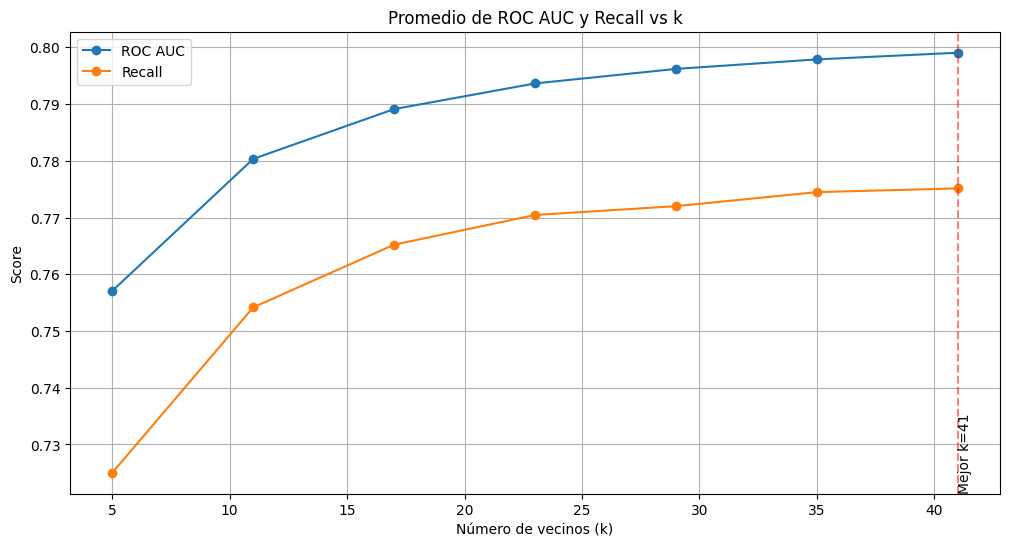

In [14]:
# Creamos un DataFrame para facilitar el análisis
results = grid_search.cv_results_

results_df = pd.DataFrame({
    'k': [params['knn__n_neighbors'] for params in results['params']],
    'weights': [params['knn__weights'] for params in results['params']],
    'roc_auc': results['mean_test_roc_auc'], 
    'recall': results['mean_test_recall']  
})

print("Results DataFrame head:")
print(results_df[['k', 'roc_auc', 'recall']].head())

# Agrupamos por k y calculamos el promedio de las métricas
k_summary = results_df.groupby('k')[['roc_auc', 'recall']].mean()

# Creamos la visualización mejorada
plt.figure(figsize=(12, 6))
plt.plot(k_summary.index, k_summary['roc_auc'], label='ROC AUC', marker='o')
plt.plot(k_summary.index, k_summary['recall'], label='Recall', marker='o')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.title('Promedio de ROC AUC y Recall vs k')

# Añadimos anotaciones para mejorar la interpretabilidad
plt.axvline(x=best_params['knn__n_neighbors'], color='r', linestyle='--', alpha=0.5)
plt.text(best_params['knn__n_neighbors'], plt.ylim()[0], f'Mejor k={best_params["knn__n_neighbors"]}', 
         rotation=90, verticalalignment='bottom')

plt.show()

Si analizamos la gráfica, obervamos que el score se ve incrementado conforme aumenta el número de vecinos (k), hasta que alcanzamos k=20, donde en comparación a k=40 la función comienza a volverse más lineal, aumentando el score en 0.01. De esta manera, vamos a realizar un segundo engrillado esta vez más refinado.

In [15]:
def get_refined_param_grid():
    
    return {
        'knn__n_neighbors': [23],
        'knn__weights': [best_params['knn__weights']]
    }

Configuramos de nuevo GridSearch para los mejores parámetros encontrados:

In [16]:
grid_search_refined = GridSearchCV(
    estimator=create_rf_pipeline(),
    param_grid=get_refined_param_grid(),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),
    scoring={
        'roc_auc': make_custom_roc_auc_scorer(),
        'accuracy': make_scorer(accuracy_score),
        'recall': make_scorer(recall_score, pos_label=1),
        'f2': make_scorer(fbeta_score, beta=2)
    },
    refit='f2',
    n_jobs=-1,
    verbose=1
)

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Ejecutamos la búsqueda en grid refinada

In [17]:
grid_search_refined.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=ProbabilityPipeline(steps=[('type_preserver',
                                                   TypePreserver()),
                                                  ('knn', GowerKNN())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [23], 'knn__weights': ['uniform']},
             refit='f2',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f2': make_scorer(fbeta_score, response_method='predict', beta=2),
                      'recall': make_scorer(recall_score, response_method='predict', pos_label=1),
                      'roc_auc': make_scorer(_custom_roc_auc_score, response_method='predict_proba')},
             verbose=1)

Imprimimos las soluciones obtenidas

In [18]:
def find_optimal_threshold(fpr, tpr, thresholds, min_recall=0.85):
    for i, threshold in enumerate(thresholds):
        if tpr[i] >= min_recall:
            return threshold
    return thresholds[np.argmax(tpr - fpr)]


Best parameters: {'knn__n_neighbors': 23, 'knn__weights': 'uniform'}
Best cross-validation accuracy: 0.7583380368989746

Optimal Threshold: 0.43

Final Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

         0.0       0.81      0.61      0.69      7070
         1.0       0.68      0.85      0.76      7069

    accuracy                           0.73     14139
   macro avg       0.74      0.73      0.73     14139
weighted avg       0.74      0.73      0.73     14139


Test set accuracy with Optimal Threshold: 0.7297


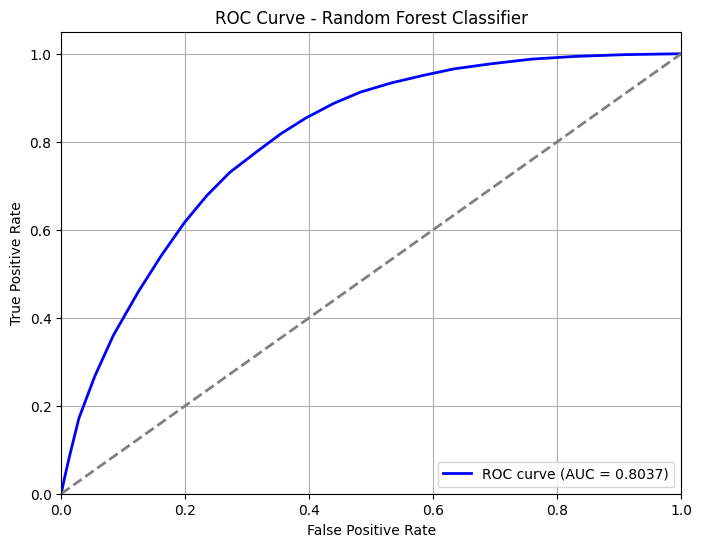


Confusion Matrix with Optimal Threshold:


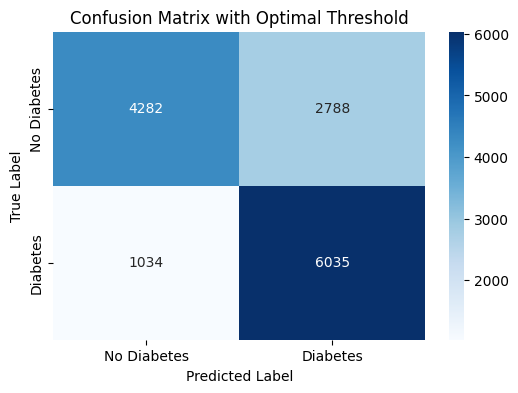

In [19]:
print("\nBest parameters:", grid_search_refined.best_params_)
print("Best cross-validation accuracy:", grid_search_refined.best_score_)

# Realizamos predicciones en el conjunto de prueba
y_pred = grid_search_refined.predict(X_test)
y_pred_proba = grid_search_refined.predict_proba(X_test)[:, 1]

# Calculamos la curva ROC y obtenemos los verdaderos y falsos positivos (TPR y FPR) junto con los umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Identificamos el umbral óptimo basándonos en la curva ROC
optimal_threshold = find_optimal_threshold(fpr, tpr, thresholds)
print(f"\nOptimal Threshold: {optimal_threshold:.2f}")

# Ajustamos las predicciones utilizando el umbral óptimo
y_pred_final = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluamos las métricas del modelo
print("\nFinal Classification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_final))

# Calculamos el accuracy del conjunto de prueba con el umbral óptimo
accuracy_final = accuracy_score(y_test, y_pred_final)
print(f"\nTest set accuracy with Optimal Threshold: {accuracy_final:.4f}")

# Representamos la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Finalmente, calculamos matriz de confusión
cm_final = confusion_matrix(y_test, y_pred_final)
print("\nConfusion Matrix with Optimal Threshold:")
plt.figure(figsize=(6, 4))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix with Optimal Threshold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Una vez analizada la solución, podemos concluir:
- ROC AUC: 0.8304, lo que indica una mejor capacidad para distinguir entre las clases.
- Accuracy: 0.7519, reflejando un aumento en la proporción de predicciones correctas respecto a KNN

Random Forest logró, aunque levemente, un mejor rendimiento general en comparación con KNN. Asimismo, gracias al uso de F2-Score como métrica predominante (dando más peso al recall que a la precisión), se ha priorizado la capacidad del modelo para detectar la mayor cantidad de casos positivos posibles (personas con diabetes), a cambio de un incremento en los falsos positivos. Esto se debe a que un falso negativo puede tener consecuencias serias en la práctica clínica, ya que el paciente no recibirá tratamiento ni seguimiento médico adecuado, derivando en complicaciones como problemas cardíacos, daño renal, ceguera o incluso la muerte. Por otro lado, un falso positivo genera una situación mucho menos grave: el paciente será sometido a pruebas adicionales para descartar la enfermedad, pero no compromete directamente la salud del paciente.